In [6]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# from sentence_transformers import SentenceTransformer

from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# import drawing_utils as drawing
import importlib
import scoring

In [7]:
## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [8]:
results_dir

'/Users/will/compositional-abstractions-ms/results'

## Read dataframes

In [9]:
# read in dataframes from each eventType)
df_block = pd.read_csv(os.path.join(csv_dir,'df_block.csv'))
df_chat = pd.read_csv(os.path.join(csv_dir,'df_chat.csv'))
df_exit = pd.read_csv(os.path.join(csv_dir,'df_exit.csv'))
df_trial = pd.read_csv(os.path.join(csv_dir,'df_trial.csv'))

In [10]:
print('n:', df_block.gameid.nunique())

n: 73


In [11]:
# iterationNames
list(df_trial.iterationName.unique())

['pilot0', 'pilot1', 'pilot2', 'pilot3', 'pilot4', 'pilot4b']

## Exclusion criteria

In [12]:
# 75% Accuracy on 75% of trials
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']

df75 = df75[df75['trials']>=9]
includedGames = list(df75.reset_index().gameid)

print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75))

Total dyads achieving 75% Accuracy on 75% of trials: 49


In [13]:
# Exclude from analysis
df_block = df_block[df_block.gameid.isin(includedGames)]
df_chat = df_chat[df_chat.gameid.isin(includedGames)]
df_exit = df_exit[df_exit.gameid.isin(includedGames)]
df_trial = df_trial[df_trial.gameid.isin(includedGames)]

## Task performance

For accuracy, see .Rmd

# Word Change

In [14]:
df_ref_exps = pd.read_csv(os.path.join(csv_dir,'df_ref_exps.csv'))
df_ref_exps.head()

,Unnamed: 0,dyad_gameid,trial_num,turn_num,message_id,workerID,block,phrases,scene,tower,message_num,message,content,refExps,leftTarget,rightTarget,tower_pair,rep
0,0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,julia,2,two blue,0.0,0,0,two blue blocks on left and right side of left...,two blue,NaN,L,Pi,L_Pi,1
1,1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,justin,2,two blue blocks,0.0,0,0,two blue blocks on left and right side of left...,two blue blocks,NaN,L,Pi,L_Pi,1
2,2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,julia,2,two red,0.0,0,1,two red block on top of left blue block just p...,two red,NaN,L,Pi,L_Pi,1
3,3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,justin,2,two red block,0.0,0,1,two red block on top of left blue block just p...,two red block,NaN,L,Pi,L_Pi,1
4,4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,4,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,julia,2,two red,0.0,0,2,two red block one space apart on right line,two red,NaN,L,Pi,L_Pi,1


In [15]:
df_ref_exps.groupby('rep')['trial_num'].value_counts()

rep  trial_num
1    0.0          1040
     1.0           948
     2.0           896
2    3.0           788
     4.0           712
     5.0           672
3    6.0           628
     7.0           608
     8.0           596
4    9.0           572
     11.0          572
     10.0          540
Name: trial_num, dtype: int64

In [16]:
df_ref_exps.loc[:,'content'] = df_ref_exps.loc[:,'content'].astype(str)
df_ref_exps['content'].head()

0           two blue
1    two blue blocks
2            two red
3      two red block
4            two red
Name: content, dtype: object

In [17]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

df_ref_exps['content'] = df_ref_exps['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_ref_exps['content'].head()

0           two blue
1    two blue blocks
2            two red
3      two red block
4            two red
Name: content, dtype: object

In [18]:
# convert number words

def num_2_words(sentence):
    out = ""
    for word in sentence.split():
        try:
            o = num2words(word)
        except:
            o = word
        out = out+" "+ o
    return out

df_ref_exps['content'] = df_ref_exps['content'].apply(lambda x: num_2_words(x))

In [19]:
# lemmatize
import nltk
from nltk.tokenize import RegexpTokenizer


tokenizer = RegexpTokenizer(r'\w+')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]

df_ref_exps['BOW_lemmatized'] = df_ref_exps['content'].apply(lemmatize_text)
df_ref_exps['BOW_lemmatized'] = df_ref_exps['BOW_lemmatized'].apply(lambda x: [i.upper() for i in x])

df_ref_exps[['message','content','BOW_lemmatized']].head()

,message,content,BOW_lemmatized
0,two blue blocks on left and right side of left...,two blue,"[TWO, BLUE]"
1,two blue blocks on left and right side of left...,two blue blocks,"[TWO, BLUE, BLOCK]"
2,two red block on top of left blue block just p...,two red,"[TWO, RED]"
3,two red block on top of left blue block just p...,two red block,"[TWO, RED, BLOCK]"
4,two red block one space apart on right line,two red,"[TWO, RED]"


In [20]:
## get work frequencies
df_ref_exps['word_freq'] = df_ref_exps['BOW_lemmatized'].apply(lambda x: Counter(x))
df_ref_exps.head()

,Unnamed: 0,dyad_gameid,trial_num,turn_num,message_id,workerID,block,phrases,scene,tower,message_num,message,content,refExps,leftTarget,rightTarget,tower_pair,rep,BOW_lemmatized,word_freq
0,0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,julia,2,two blue,0.0,0,0,two blue blocks on left and right side of left...,two blue,NaN,L,Pi,L_Pi,1,"[TWO, BLUE]","{'TWO': 1, 'BLUE': 1}"
1,1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,justin,2,two blue blocks,0.0,0,0,two blue blocks on left and right side of left...,two blue blocks,NaN,L,Pi,L_Pi,1,"[TWO, BLUE, BLOCK]","{'TWO': 1, 'BLUE': 1, 'BLOCK': 1}"
2,2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,julia,2,two red,0.0,0,1,two red block on top of left blue block just p...,two red,NaN,L,Pi,L_Pi,1,"[TWO, RED]","{'TWO': 1, 'RED': 1}"
3,3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,justin,2,two red block,0.0,0,1,two red block on top of left blue block just p...,two red block,NaN,L,Pi,L_Pi,1,"[TWO, RED, BLOCK]","{'TWO': 1, 'RED': 1, 'BLOCK': 1}"
4,4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0.0,4,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,julia,2,two red,0.0,0,2,two red block one space apart on right line,two red,NaN,L,Pi,L_Pi,1,"[TWO, RED]","{'TWO': 1, 'RED': 1}"


In [21]:
## concatenate lemmatized tokens, separated by spaces
df_ref_exps['BOW_concat'] = df_ref_exps['BOW_lemmatized'].apply(lambda x: ' '.join(x))

In [22]:
# Currently, the word counts represent the counts from all 4 of our naive raters. 
# So that we can examine how frequently different words were used, we need to convert these values into proportions.
split_words = df_ref_exps['BOW_concat'].apply(lambda x: x.split())
all_words = list(pd.Series([st for row in split_words for st in row]).unique())
support = {}
for word in all_words:
    support[word] = 0.000000001
    
def get_pdist(row):
    num_words = np.sum(list(row['word_freq'].values()))
    pdist = support.copy()
    for i, (word, count) in enumerate(row['word_freq'].items()):
        pdist[word] = count/num_words
    return pdist

In [23]:
df_ref_exps['word_pdist'] = df_ref_exps.apply(get_pdist, axis = 1)
df_ref_exps['word_pdist_numeric'] = df_ref_exps['word_pdist'].apply(lambda dist: list(dist.values()))

In [24]:
df_all_words = df_ref_exps[['dyad_gameid', 'rep', 'BOW_concat']]

In [25]:
for w in all_words:
    df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/999219942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/999219942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/999219942.py

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/999219942.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/999219942.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words.loc[:,w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/999219942.py:2: PerformanceWarning

In [26]:
df_all_words_reps = df_all_words.groupby('rep').agg(sum)
df_all_words_reps

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/3932202342.py:1: FutureWarning: The operation <built-in function sum> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  df_all_words_reps = df_all_words.groupby('rep').agg(sum)


,TWO,BLUE,BLOCK,RED,ONE,SAME,EXACT,CONSTRUCTION,LEFT,RIGHT,...,AND,THEY,MAKE,UP,IT,ANGLE,LL,CENTRED,LEFTMOST,TWR
rep,,,,,,,,,,,,,,,,,,,,,
1,367,1085,1100,1035,182,12,0,0,3,5,...,1,0,1,2,0,1,1,1,0,0
2,206,884,415,774,103,2,4,3,11,8,...,6,1,0,0,1,0,0,0,1,1
3,139,703,195,629,77,5,1,0,3,7,...,2,0,0,0,0,0,0,0,0,0
4,79,619,105,537,49,7,0,0,4,3,...,2,0,0,0,0,0,0,0,0,0


In [27]:
# examine the change in word frequencies between trials.
# prep data
df_ref_exps_rep = df_ref_exps.groupby('rep')['BOW_concat'].apply(lambda group:' '.join(group)).reset_index()
df_ref_exps_rep['word_freq'] = df_ref_exps_rep['BOW_concat'].apply(lambda x: Counter(x.split()))
df_ref_exps_rep['word_pdist'] = df_ref_exps_rep.apply(get_pdist, axis=1)
df_ref_exps_rep['word_pdist_numeric'] = df_ref_exps_rep['word_pdist'].apply(lambda dist: list(dist.values()))
df_ref_exps_rep.index=df_ref_exps_rep['rep']

In [28]:
# calculate difference in proportion between reps (currently hardcoded to be 1 and 4)
rep_a = 1 
rep_b = 4

rep_diff = {}

for _, (k, rep_a_v) in enumerate(df_ref_exps_rep.loc[rep_a,'word_pdist'].items()):
    rep_diff[k] = df_ref_exps_rep.loc[rep_b,'word_pdist'][k] - rep_a_v

In [29]:
# find largest n increase/ decrease in proportion across reps
n = 6

# find the largest increase in proportion between reps
top_n = dict(sorted(rep_diff.items(), key=lambda item: item[1], reverse=True)[:n])

# find the largest decrease in proportion between reps
bottom_n = dict(sorted(rep_diff.items(), key=lambda item: item[1], reverse=False)[:n])

df_grouped = df_ref_exps.groupby('rep').agg({'BOW_lemmatized': 'sum'})


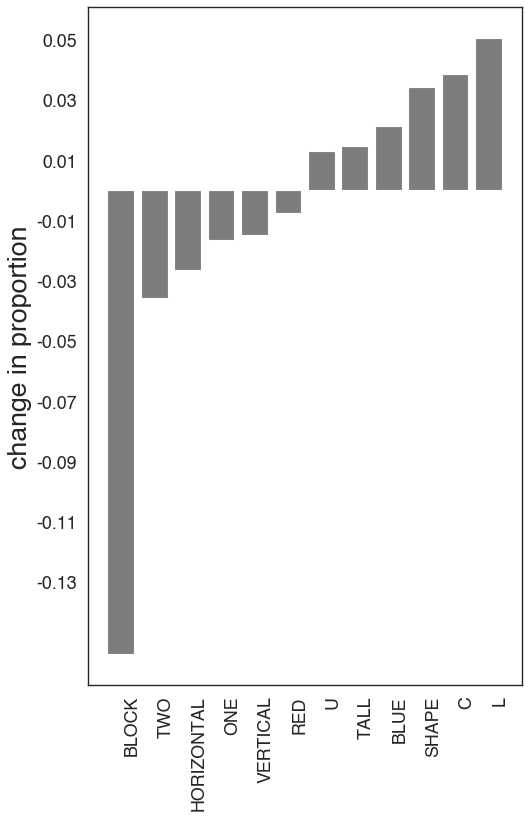

In [30]:
from matplotlib.ticker import FormatStrFormatter

font = {'fontname':'Helvetica'}
sns.set_theme(style='white')

x_limit = 6

labels, values = zip(*rep_diff.items())

# sort your values in descending order
indSort_high = np.argsort(values)[::-1]
indSort_low = np.argsort(values)

# rearrange your data
#labels = np.array(labels)[indSort_high][:x_limit][::-1]
labels = np.concatenate([np.array(labels)[indSort_low][:x_limit],np.array(labels)[indSort_high][:x_limit][::-1]])
#values = np.array(values)[indSort_high][:x_limit][::-1]
values = np.concatenate([np.array(values)[indSort_low][:x_limit], np.array(values)[indSort_high][:x_limit][::-1]])

indexes = np.arange(len(labels))

bar_width = 0.35

fig = plt.figure(num=None, figsize=(7, 11), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.bar(indexes, values, color = "#7D7D7D")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# add labels
plt.yticks(fontsize=16, **font)
plt.xticks(indexes + bar_width, labels,  rotation='vertical', fontsize=16, **font)
plt.ylabel("change in proportion", size = 24, **font)
plt.yticks(np.arange(-.13,.06, .02))
ax.axes.get_xaxis().set_visible(True)
#plt.title("highest delta words", size = 24, **font)
plt.show()

## Cluster analyses

In [31]:
df_all_words = df_ref_exps[['dyad_gameid', 'rep', 'BOW_concat']].copy()

for w in all_words:
    df_all_words[w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
    
# df_all_words_reps = df_all_words.groupby('rep').agg(sum)
# df_all_words_reps
# df_all_words_reps = df_all_words_reps.sort_values(by = 0, axis = 1)
df_all_words

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/2122037988.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words[w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/2122037988.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words[w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/2122037988.py:4: PerformanceWarning: DataFra

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/2122037988.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words[w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/2122037988.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words[w] = df_all_words['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/2122037988.py:4: PerformanceWarning: DataFra

,dyad_gameid,rep,BOW_concat,TWO,BLUE,BLOCK,RED,ONE,SAME,EXACT,...,AND,THEY,MAKE,UP,IT,ANGLE,LL,CENTRED,LEFTMOST,TWR
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,TWO BLUE,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,TWO BLUE BLOCK,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,TWO RED,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,TWO RED BLOCK,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,TWO RED,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8567,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,4,SAME,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8568,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,4,TWO BLUE,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8569,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,4,BLUE,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8570,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,4,BLUE,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# word count (across all four raters)

df_ref_exps_trial = df_ref_exps.groupby(['dyad_gameid','rep','trial_num'])['BOW_concat'].apply(lambda x: ' '.join(x)).reset_index()
df_ref_exps_trial['word_freq'] = df_ref_exps_trial['BOW_concat'].apply(lambda x: Counter(x.split()))
df_ref_exps_trial

,dyad_gameid,rep,trial_num,BOW_concat,word_freq
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,0.0,TWO BLUE TWO BLUE BLOCK TWO RED TWO RED BLOCK ...,"{'TWO': 12, 'BLUE': 8, 'BLOCK': 14, 'RED': 12,..."
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,1.0,TWO BLUE TWO BLUE BLOCK TWO RED TWO RED BLOCK ...,"{'TWO': 12, 'BLUE': 12, 'BLOCK': 15, 'RED': 8,..."
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,2.0,BLUE TWO RED BLUE BLOCK TWO RED BLUE BLUE BLOC...,"{'BLUE': 13, 'TWO': 4, 'RED': 8, 'BLOCK': 13, ..."
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,2,3.0,EXACT CONSTRUCTION EXACT CONSTRUCTION ONE RED ...,"{'EXACT': 3, 'CONSTRUCTION': 3, 'ONE': 11, 'RE..."
4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,2,4.0,BLUE TWO RED ONE BLUE BLOCK TWO RED BLOCK BLUE...,"{'BLUE': 12, 'TWO': 12, 'RED': 8, 'ONE': 6, 'B..."
...,...,...,...,...,...
583,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,3,7.0,BLUE BLUE BLOCK BLUE BLUE ONE TWO RED TWO RED ...,"{'BLUE': 16, 'BLOCK': 6, 'ONE': 2, 'TWO': 8, '..."
584,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,3,8.0,BLUE BLUE BLOCK TWO RED TWO RED BLUE BLUE RED ...,"{'BLUE': 12, 'BLOCK': 3, 'TWO': 8, 'RED': 8, '..."
585,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,4,9.0,BLUE BLUE TWO RED TWO RED BLUE BLUE BLUE ABLUE...,"{'BLUE': 13, 'TWO': 8, 'RED': 8, 'ABLUE': 3}"
586,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,4,10.0,RED RED TWO BLUE TWO BLUE BLUE BLUE TWO RED ...,"{'RED': 8, 'TWO': 8, 'BLUE': 12, 'SAME': 2}"


In [33]:
df_all_words_trial = df_ref_exps_trial[['dyad_gameid', 'rep', 'trial_num' ,'BOW_concat']]

for w in all_words:
    df_all_words_trial[w] = df_all_words_trial['BOW_concat'].apply(lambda row: int(w in row.split()))

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/657284722.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words_trial[w] = df_all_words_trial['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/657284722.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all_words_trial[w] = df_all_words_trial['BOW_concat'].apply(lambda row: int(w in row.split()))
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/657284722.py:4: Perfor

In [34]:
r1_clustering_original = AffinityPropagation(random_state=0, damping=0.5)\
    .fit(df_all_words_trial[df_all_words_trial.rep == 1].loc[:, 'TWO':'TWR'])

r4_clustering_original = AffinityPropagation(random_state=0, damping=0.5)\
    .fit(df_all_words_trial[df_all_words_trial.rep == 4].loc[:,'TWO':'TWR'])

df_all_words_trial.loc[(df_all_words_trial.rep == 1), 'r0_label'] = r1_clustering_original.labels_
df_all_words_trial.loc[(df_all_words_trial.rep == 4), 'r4_label'] = r4_clustering_original.labels_

In [35]:
r4_clustering_original.labels_

array([21,  0,  0, 17, 20, 17,  7,  5,  1,  5,  7,  1,  3,  2,  3,  9, 18,
        1, 11, 11, 11,  4,  4,  9, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       21, 17,  7,  5,  1, 18, 16,  7, 23,  7,  7,  6,  6,  6, 20, 18, 20,
       19, 21,  9, 23, 23, 23, 17, 17, 17,  7, 16,  7,  8,  8,  8,  9,  5,
        1, 18, 16,  7,  9,  9,  9, 21,  5,  9, 19, 21,  9, 10, 10,  7,  1,
       17, 17, 11, 17, 17, 11, 17, 11, 12, 13, 14, 11,  9, 11,  9,  9,  9,
       16,  1,  5, 15, 15, 15,  7, 18, 16, 17, 17, 17, 20, 16, 18,  1,  7,
        5, 19, 19, 19, 20, 20, 20, 21, 22, 22, 11, 17, 16, 23, 23, 23, 24,
       24, 24, 17, 17, 17, 25,  9,  7, 21, 21, 21])

In [36]:
len(r1_clustering_original.labels_)

147

In [37]:
df_all_words_trial[(df_all_words_trial.rep == 1)].loc[:,'TWO':'TWR']

,TWO,BLUE,BLOCK,RED,ONE,SAME,EXACT,CONSTRUCTION,LEFT,RIGHT,...,AND,THEY,MAKE,UP,IT,ANGLE,LL,CENTRED,LEFTMOST,TWR
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
566,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
576,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
577,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
df_all_words_trial

,dyad_gameid,rep,trial_num,BOW_concat,TWO,BLUE,BLOCK,RED,ONE,SAME,...,MAKE,UP,IT,ANGLE,LL,CENTRED,LEFTMOST,TWR,r0_label,r4_label
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,0.0,TWO BLUE TWO BLUE BLOCK TWO RED TWO RED BLOCK ...,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0.0,NaN
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,1.0,TWO BLUE TWO BLUE BLOCK TWO RED TWO RED BLOCK ...,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0.0,NaN
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,2.0,BLUE TWO RED BLUE BLOCK TWO RED BLUE BLUE BLOC...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0.0,NaN
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,2,3.0,EXACT CONSTRUCTION EXACT CONSTRUCTION ONE RED ...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,NaN,NaN
4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,2,4.0,BLUE TWO RED ONE BLUE BLOCK TWO RED BLOCK BLUE...,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,3,7.0,BLUE BLUE BLOCK BLUE BLUE ONE TWO RED TWO RED ...,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,NaN,NaN
584,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,3,8.0,BLUE BLUE BLOCK TWO RED TWO RED BLUE BLUE RED ...,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,NaN,NaN
585,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,4,9.0,BLUE BLUE TWO RED TWO RED BLUE BLUE BLUE ABLUE...,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,NaN,21.0
586,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,4,10.0,RED RED TWO BLUE TWO BLUE BLUE BLUE TWO RED ...,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,NaN,21.0


## visualize using tsne, colored by clusters from rep 1 (above)

In [34]:
perplexity = 10

/Users/will/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/will/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


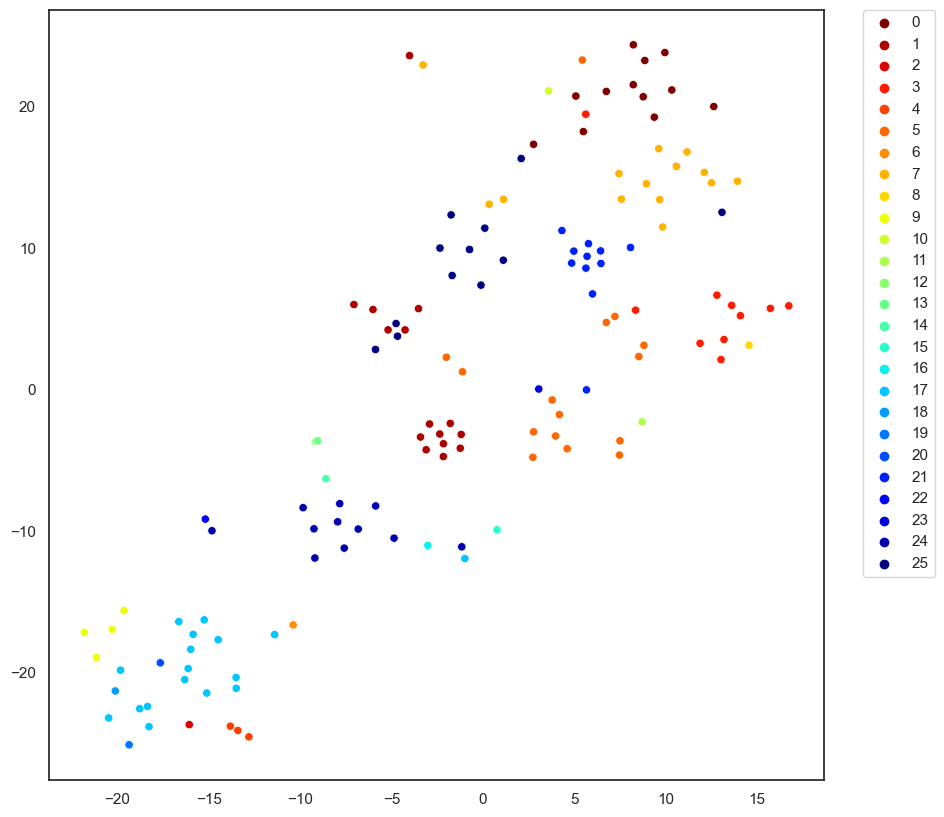

In [35]:
# rep 1
tsne = TSNE(perplexity = perplexity)
X_embedded = tsne.fit_transform(df_all_words_trial[(df_all_words_trial.rep == 1)].loc[:,'TWO':'TWR'])
cluster_labels = r1_clustering_original.labels_

plt.figure(figsize=(10,10))

palette = sns.color_palette("bright", len(cluster_labels))
sns.scatterplot(x = X_embedded[:,0], 
                y = X_embedded[:,1], 
                hue=cluster_labels, 
                legend='full', 
                palette='jet_r')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

/Users/will/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/will/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


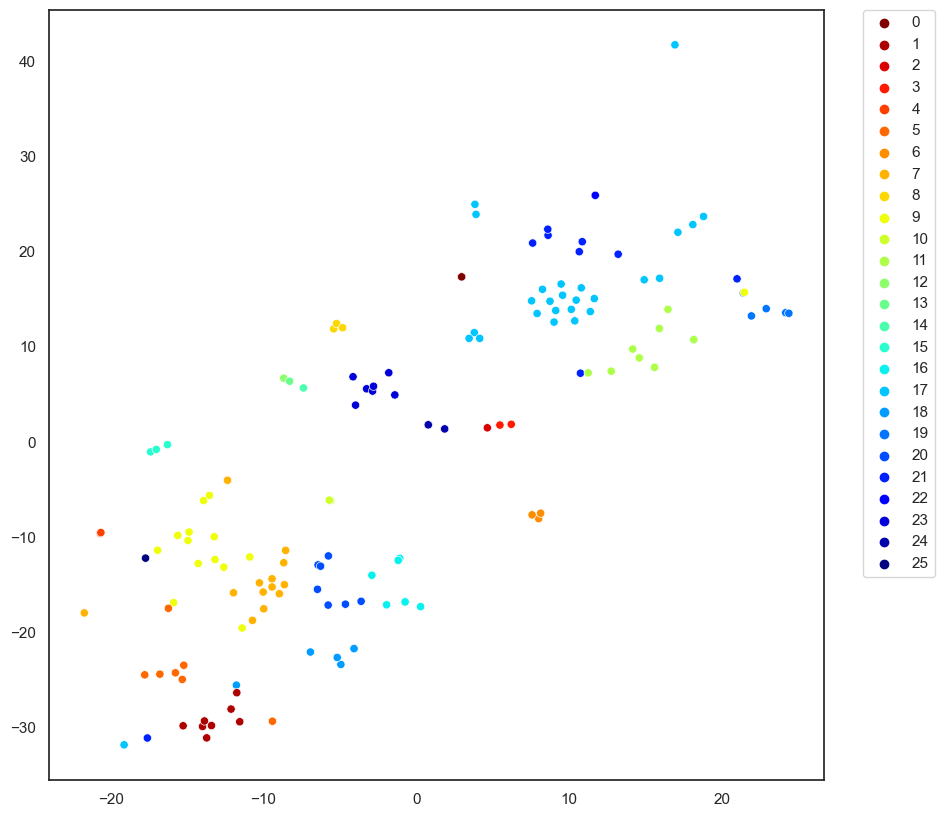

In [36]:
# rep 4

tsne = TSNE(perplexity=perplexity)
X_embedded = tsne.fit_transform(df_all_words_trial[(df_all_words_trial.rep == 4)].loc[:,'TWO':'TWR'])
cluster_labels = r4_clustering_original.labels_

plt.figure(figsize=(10,10))

palette = sns.color_palette("bright", len(cluster_labels))
sns.scatterplot(x = X_embedded[:,0], 
                y = X_embedded[:,1], 
                hue=cluster_labels, 
                legend='full', 
                palette='jet_r')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

## What we had for cogsci

/Users/will/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/will/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


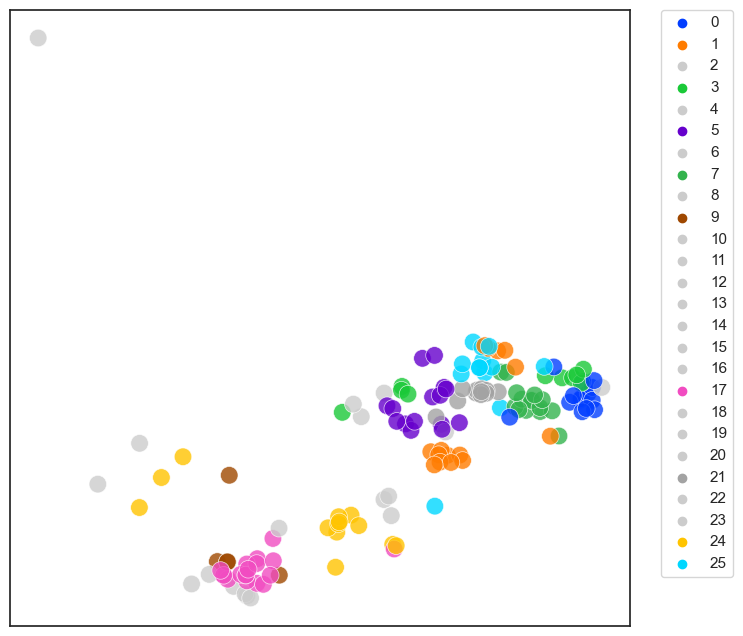

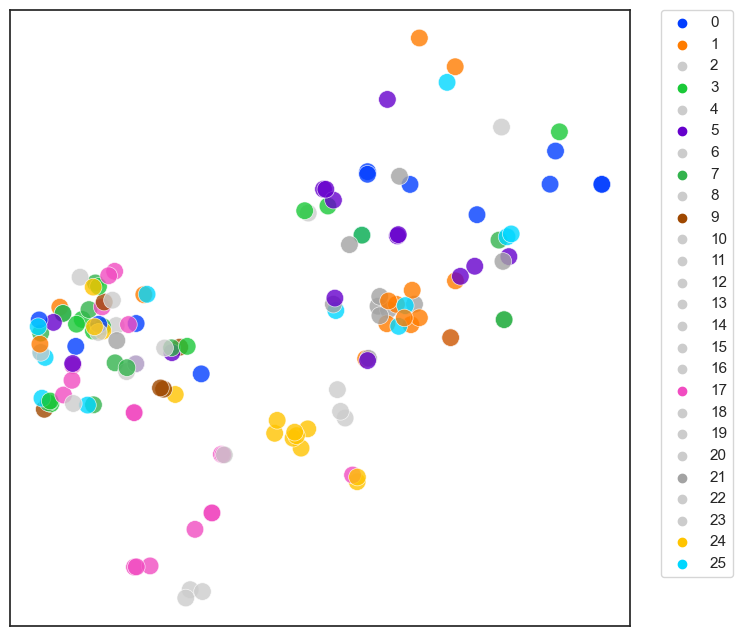

In [41]:

np.random.seed(0)
tsne = TSNE(perplexity=10)

both_reps = pd.concat([df_all_words_trial[(df_all_words_trial.rep == 1)].loc[:,'TWO':'TWR'], df_all_words_trial[(df_all_words_trial.rep == 4)].loc[:,'TWO':'TWR']], axis=0)

X_embedded = tsne.fit_transform(both_reps)
#cluster_labels = r0_clustering_original.labels_ + r3_clustering_original.labels_
cluster_labels = np.concatenate((r1_clustering_original.labels_, r1_clustering_original.labels_)) # visualizations of both reps are colored by their final cluster assignment, to show convergence towards strategies

# r3_X_embedded = tsne.fit_transform(df_all_words_trial[(df_all_words_trial.repNum == 3)].loc[:,'two':'ablue'])
# r3_cluster_labels = r3_clustering_original.labels_

# colors = pd.concat([df_all_words_trial[(df_all_words_trial.rep == 1)], (df_all_words_trial[(df_all_words_trial.rep == 4)])], axis = 0).rep

n = int(len(X_embedded[:,0])/2)

# for i, x in enumerate(X_embedded[:n,0]):
#     plt.plot([x,X_embedded[i+n,0]], [X_embedded[i,1],X_embedded[i+n,1]], color = (0,0,0,0.05) )

palette = np.array(sns.color_palette("jet_r", len(set(cluster_labels))))

palette[[(Counter(cluster_labels[n:])[x] <= 3) for x in set(cluster_labels)]] = (0.8,0.8,0.8)

palette[[(Counter(cluster_labels[n:])[x] > 3) for x in set(cluster_labels)]] = sns.color_palette("bright", len(set(cluster_labels)) - sum([(Counter(cluster_labels[n:])[x] <= 3) for x in set(cluster_labels)]))

palette = list(palette)

palette[5] = ([0.4,0.0,0.8])

# palette[6] = ([0.75,0.05,0.07])

palette[7] = ([0.2,0.7,0.3])

# palette[7] = ([0.2,0.7,0.3])

sns.set_style('white')

plt.figure(figsize=(8,8))
sns.scatterplot(x = X_embedded[:n,0], y = X_embedded[:n,1], hue=cluster_labels[:n], legend='full', palette=palette, alpha=0.8, s=160, linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

# plt.savefig('../results/plots/rep1_clusters.pdf')

plt.figure(figsize=(8,8))

# for i, x in enumerate(X_embedded[:n,0]):
#     plt.plot([x,X_embedded[i+n,0]], [X_embedded[i,1],X_embedded[i+n,1]], color = palette[cluster_labels[i+n]], alpha=0.1)

sns.scatterplot(x = X_embedded[n:,0], y = X_embedded[n:,1], hue=cluster_labels[n:], legend='full', palette=palette, alpha=0.8, s=160, linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False)

# plt.savefig('../results/plots/rep4_clusters.pdf')


In [42]:
df_both_reps = pd.concat([df_all_words_trial[(df_all_words_trial.rep == 1)], df_all_words_trial[(df_all_words_trial.rep == 4)]], axis=0)
df_both_reps['label'] = cluster_labels
df_tmp = df_both_reps[df_both_reps.label == 9][['rep','BOW_concat']]
df_tmp['BOW_concat'] =  df_tmp['BOW_concat'].apply(lambda words: pd.unique(words.split(' ')))
df_tmp

,rep,BOW_concat
25,1,"[L, TWO, HORIZONTAL, VERT, ONE, 2, VERTICAL, C..."
26,1,"[C, UPSIDE, U, ONE, VERT, TWO, HORIZONTAL]"
288,1,"[L, 5, HIGH, 4, WIDE, HORIZONTAL, TWO, VERTICA..."
289,1,"[TWO, HORIZONTAL, VERTICAL, ONE, VETICAL]"
290,1,"[HORIZONTAL, TWO, VERTICAL, ONE, 1]"
34,4,"[UPSIDE, U, LONG, C]"
35,4,"[UPSIDE, U, BIG, L]"
297,4,"[C, SHAPE, L]"
298,4,"[N, SHAPE, C, LOWERCASE]"
299,4,"[N, SHAPE, L, LOWERCASE]"


## tsne both reps together- compare reps

/Users/will/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/will/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/2549608433.py:14: UserWarning: The palette list has more values (26) than needed (2), which may not be intended.
  sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue=rep_labels, legend='full', palette=palette, alpha=0.8, s=160, linewidth=0.5)


<Figure size 800x800 with 0 Axes>

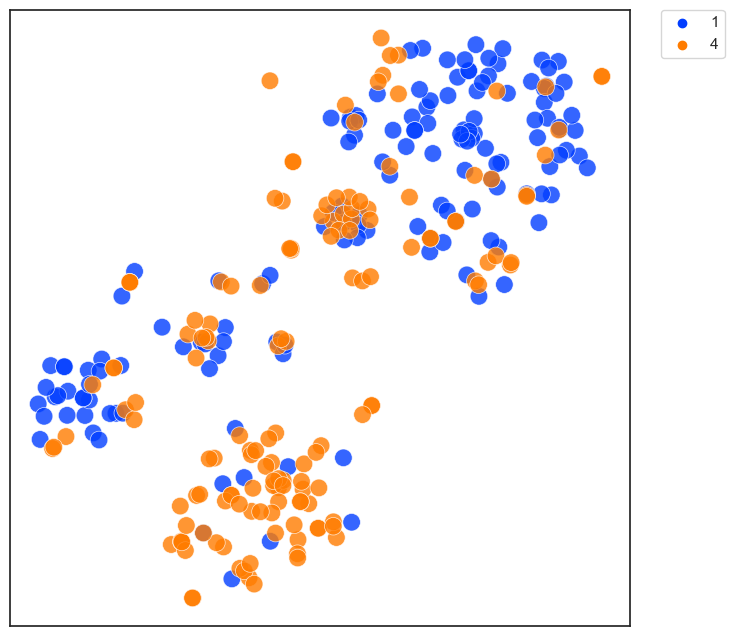

<Figure size 800x800 with 0 Axes>

In [43]:
# visualizations using tsne, colored by rep

np.random.seed(0)
tsne = TSNE(perplexity=15)

both_reps = pd.concat([df_all_words_trial[(df_all_words_trial.rep == 1)].loc[:,'TWO':'TWR'], df_all_words_trial[(df_all_words_trial.rep == 4)].loc[:,'TWO':'TWR']], axis=0)
rep_labels = list(pd.concat([df_all_words_trial[(df_all_words_trial.rep == 1)].rep, df_all_words_trial[(df_all_words_trial.rep == 4)].rep]))

X_embedded = tsne.fit_transform(both_reps)

sns.set_style('white')

plt.figure(figsize=(8,8))
sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue=rep_labels, legend='full', palette=palette, alpha=0.8, s=160, linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

# plt.savefig('../results/plots/rep1_clusters.pdf')

plt.figure(figsize=(8,8))

# for i, x in enumerate(X_embedded[:n,0]):
#     plt.plot([x,X_embedded[i+n,0]], [X_embedded[i,1],X_embedded[i+n,1]], color = palette[cluster_labels[i+n]], alpha=0.1)

# sns.scatterplot(x = X_embedded[n:,0], y = X_embedded[n:,1], hue=cluster_labels[n:], legend='full', palette=palette, alpha=0.8, s=160, linewidth=0.5)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
# plt.tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     left=False,         # ticks along the top edge are off
#     labelbottom=False,
#     labelleft=False)

# plt.savefig('../results/plots/rep4_clusters.pdf')


### Same again, with pca first

#### Colored by rep

/Users/will/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/will/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_8308/3275997621.py:18: UserWarning: The palette list has more values (26) than needed (2), which may not be intended.
  sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue=rep_labels, legend='full', palette=palette, alpha=0.8, s=160, linewidth=0.5)


<Figure size 800x800 with 0 Axes>

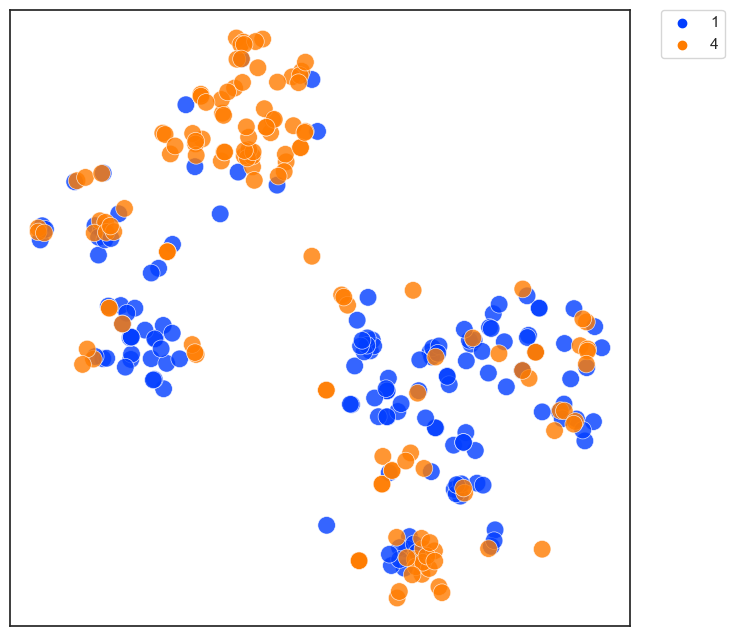

<Figure size 800x800 with 0 Axes>

In [49]:
# visualizations using tsne, colored by clusters above (I don't know if this is a silly thing to do)

np.random.seed(0)

both_reps = pd.concat([df_all_words_trial[(df_all_words_trial.rep == 1)].loc[:,'TWO':'TWR'], df_all_words_trial[(df_all_words_trial.rep == 4)].loc[:,'TWO':'TWR']], axis=0)
rep_labels = list(pd.concat([df_all_words_trial[(df_all_words_trial.rep == 1)].rep, df_all_words_trial[(df_all_words_trial.rep == 4)].rep]))

# pca first
pca = PCA(n_components=30)
pca_result = pca.fit_transform(both_reps)

tsne = TSNE(perplexity=15)
X_embedded = tsne.fit_transform(pca_result)

sns.set_style('white')

plt.figure(figsize=(8,8))
sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue=rep_labels, legend='full', palette=palette, alpha=0.8, s=160, linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

# plt.savefig('../results/plots/rep1_clusters.pdf')

plt.figure(figsize=(8,8))

# for i, x in enumerate(X_embedded[:n,0]):
#     plt.plot([x,X_embedded[i+n,0]], [X_embedded[i,1],X_embedded[i+n,1]], color = palette[cluster_labels[i+n]], alpha=0.1)

# sns.scatterplot(x = X_embedded[n:,0], y = X_embedded[n:,1], hue=cluster_labels[n:], legend='full', palette=palette, alpha=0.8, s=160, linewidth=0.5)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
# plt.tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     left=False,         # ticks along the top edge are off
#     labelbottom=False,
#     labelleft=False)

# plt.savefig('../results/plots/rep4_clusters.pdf')


## clustering as arrows from first to last rep, colored by last rep

In [177]:
r1_clustering_original = AffinityPropagation(random_state=0, damping=0.8)\
    .fit(df_all_words_trial[df_all_words_trial.rep == 1].loc[:, 'TWO':'TWR'])

r4_clustering_original = AffinityPropagation(random_state=0, damping=0.8)\
    .fit(df_all_words_trial[df_all_words_trial.rep == 4].loc[:,'TWO':'TWR'])

df_all_words_trial.loc[(df_all_words_trial.rep == 1), 'r0_label'] = r1_clustering_original.labels_
df_all_words_trial.loc[(df_all_words_trial.rep == 4), 'r4_label'] = r4_clustering_original.labels_

In [178]:
cluster_labels = np.concatenate((r4_clustering_original.labels_, r4_clustering_original.labels_)) # visualizations of both reps are colored by their final cluster assignment, to show convergence towards strategies
palette = np.array(sns.color_palette("colorblind", len(set(cluster_labels))))

palette[[(Counter(cluster_labels[n:])[x] <= 3) for x in set(cluster_labels)]] = (0.8,0.8,0.8)

palette[[(Counter(cluster_labels[n:])[x] > 3) for x in set(cluster_labels)]] = sns.color_palette("bright", len(set(cluster_labels)) - sum([(Counter(cluster_labels[n:])[x] <= 3) for x in set(cluster_labels)]))

['x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x']

/Users/will/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/will/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


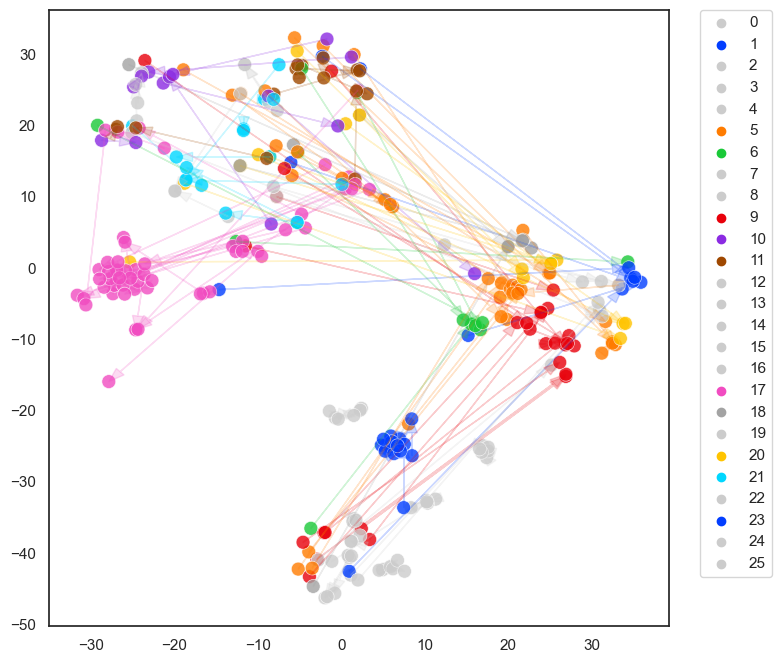

In [237]:
# visualizations using tsne, colored by clusters above (I don't know if this is a silly thing to do)
plt.figure(figsize=(8,8))

np.random.seed(0)

both_reps = pd.concat([df_all_words_trial[(df_all_words_trial.rep == 1)].loc[:,'TWO':'TWR'], df_all_words_trial[(df_all_words_trial.rep == 4)].loc[:,'TWO':'TWR']], axis=0)
# rep_labels = list(pd.concat([df_all_words_trial[(df_all_words_trial.rep == 1)].rep, df_all_words_trial[(df_all_words_trial.rep == 4)].rep]))

# pca first
pca = PCA(n_components=30)
pca_result = pca.fit_transform(both_reps)

tsne = TSNE(perplexity=10)
X_embedded = tsne.fit_transform(pca_result)

sns.set_style('white')

# plt.figure(figsize=(8,8))
sns.scatterplot(x = X_embedded[:,0], 
                y = X_embedded[:,1], 
                hue=np.concatenate([cluster_labels[n:], cluster_labels[n:]]), 
                legend='full', 
                palette=list(palette), 
                alpha=0.8, s=100, 
                linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
# plt.tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     left=False,         # ticks along the top edge are off
#     labelbottom=False,
#     labelleft=False) # labels along the bottom edge are off

# plt.savefig('../results/plots/rep1_clusters.pdf')

for i, x in enumerate(X_embedded[:n,0]):
    # plt.plot([x,X_embedded[i+n,0]], [X_embedded[i,1],X_embedded[i+n,1]], color = (0,0,0,0.05), palette=palette)
    # set color to be that of final rep
#     plt.plot([x,X_embedded[i+n,0]], [X_embedded[i,1],X_embedded[i+n,1]], color = palette[cluster_labels[i+n]], alpha=0.2,)
    # Add the arrow at the end of the line
    plt.arrow(x, X_embedded[i, 1], X_embedded[i+n, 0]-x, X_embedded[i+n, 1]-X_embedded[i, 1], shape='full', lw=1, length_includes_head=True, head_width=1.3, color = palette[cluster_labels[i+n]], alpha=0.2)


In [203]:
df_ref_exps_trial.loc[:,'r4_cluster'] = np.tile(r4_clustering_original.labels_, 4)

In [204]:
df_ref_exps_trial.query('rep==4').groupby('r4_cluster').get_group(5)['BOW_concat']

10     RED ONE RED BLOCK LEFT RIGHT SIDE BLUE ONE BLU...
70     UPSIDEDOWN U SHAPE UPSIDEDOWN U SHAPE TALL C S...
71     UPSIDEDOWN U SHAPE UPSIDEDOWN U SHAPE TALL L S...
81     BLUE 2 RED BLUE 1 BLUE 2 RED 1 BLUE BLUE 2 RED...
82     RED 2 BLUE RED BLOCK 2 BLUE BLUE 2 RED BLUE 1 ...
83     RED 2 BLUE RED BLOCK 2 BLUE BLUE 2 RED BLUE EI...
118    RED RED BLUE BLUE RED RED BLUE BLUE BLUE BLUE ...
143    BLUE BLUE RED RED NAN RED RED RED BLUE BLUE BL...
153                                      C L C L C L C L
190    V BLK V BLK H H V BLK V BLK H H H BLK H BLK V ...
191    H BLK H BLK V V V V H H H BLK H BLK V V V V H ...
334    SQUARE BOTTOM SQUARE BOTTOM BLUE CAPITAL C BLU...
335    BLUE CAPITAL C CAPITAL C BLUE BLOCK CAPITAL L ...
477    UPSIDEDOWN U L UPSIDEDOWN U L UPSIDEDOWN U L U...
501      BIG C BIG L BIG C BIG L BIG C BIG L BIG C BIG L
502            BIG C TABLE BIG C TABLE BIG C TABLE BIG C
503            BIG L TABLE BIG L TABLE BIG L TABLE BIG L
549    VERTICAL VERTICAL VERTIC

## Use SBERT

In [61]:
from sentence_transformers import SentenceTransformer

In [51]:
df_messages = df_chat[~df_chat.practice].copy()
df_messages.loc[:,'rep'] =  df_messages['repNum'].apply(int) + 1

In [52]:
# using '.' as separater
df_sentences = df_messages.groupby(['gameid','trialNum','rep'])['content'].apply(lambda x : '. '.join(x)).reset_index()
df_sentences = df_sentences[df_sentences.rep.isin([1,4])].sort_values(['rep','gameid']).reset_index()
df_sentences['content'] = df_sentences['content'].apply(lambda s: s.replace(' .', '.'))

In [4]:
df_sentences

NameError: name 'df_sentences' is not defined

In [3]:
try:
#     model = SentenceTransformer('all-MiniLM-L6-v2')
    model = SentenceTransformer('all-mpnet-base-v2') 
except Exception as e:
    print(e)

name 'SentenceTransformer' is not defined


In [1]:
sentences = df_sentences['content']
embeddings = model.encode(sentences)

NameError: name 'df_sentences' is not defined

In [59]:
embeddings.shape

(294, 384)

In [ ]:
# visualizations using tsne, colored by clusters above (I don't know if this is a silly thing to do)

np.random.seed(0)

# both_reps = pd.concat([df_all_words_trial[(df_all_words_trial.rep == 1)].loc[:,'TWO':'TWR'], df_all_words_trial[(df_all_words_trial.rep == 4)].loc[:,'TWO':'TWR']], axis=0)
rep_labels = list(df_sentences.rep)

# pca first
pca = PCA(n_components=30)
pca_result = pca.fit_transform(embeddings)

tsne = TSNE(perplexity=20)
X_embedded = tsne.fit_transform(pca_result)

sns.set_style('white')

plt.figure(figsize=(8,8))
sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue=rep_labels, legend='full', palette=palette, alpha=0.8, s=160, linewidth=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

# plt.savefig('../results/plots/rep1_clusters.pdf')

plt.figure(figsize=(8,8))